In [1]:
import warnings

warnings.filterwarnings("ignore")

try:
    from IPython import get_ipython

    get_ipython().magic("clear")
    get_ipython().magic("reset -f")
except:
    pass

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV

# 欄位說明

# ReadData

In [66]:
df = pd.read_csv("./SIX_CITY_CLEAN_ALL.csv", encoding="UTF-8")

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2733664 entries, 0 to 2873851
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   WHOLE_TIME      float64
 1   ACCIDENT_TYPE   float64
 2   CITY            int32  
 3   LIGHT           int32  
 4   Temperature     float64
 5   WS              float64
 6   RH              float64
 7   Precp           float64
 8   ROAD_TYPE_SUB1  int32  
 9   SIGNAL_TYPE     int32  
 10  VEHICLE_MAIN    int32  
 11  OBJ_GENDER      float64
 12  OBJ_AGE         int32  
 13  CAMERA_ID       int32  
 14  EQUIP_TYPE      int32  
dtypes: float64(7), int32(8)
memory usage: 250.3 MB


# 初步Feature移除

In [67]:
# 去除特徵
# df = df.drop(['WHOLE_DATE','WHOLE_TIME','ADMIN_UNIT'], axis=1)
df = df.drop(
    [
        "ACCIDENT_OBJ",
        "ACCIDENT_OBJ_ORDER",
        "BAR",
        "BAR_QUA",
        "BAR_VIS",
        "C_PDT_USAGE",
        "CAUSE_MAIN",
        "CAUSE_MAIN_DETAIL",
        "CAUSE_SUB_DETAIL",
        "CRASH_OTHER_MAIN",
        "CRASH_OTHER_SUB",
        "HAR",
        "LANE_LINE_EDGE",
        "LANE_LINE_SPEED",
        "LANE_MAIN",
        "LANE_SUB",
        "LOCATION_SUB",
        "OBJ_CDN_SUB",
        "PAVE_CDN",
        "PAVE_FLAW",
        "PAVE_MTL",
        "PROTECTION",
        "PUN_IGNORE_WALKER",
        "PUN_LINE_SIGNAL",
        "PUN_OVER_SPEED",
        "PUN_PARKING",
        "PUN_RED_LIGHT",
        "PUN_ROAD_KIND",
        "ROAD_TYPE_MAIN",
        "ROAD_TYPE_SUB2",
        "SPEED_LIMIT",
        "VEHICLE_SUB",
        "WEATHER",
        "LONGITUDE",
        "LATITUDE",
        "ACCIDENT_DEAD",
        "ACCIDENT_INJURY",
        "ADMIN_UNIT",
        "ACCIDENT_ADDR",
        "LOCATION_MAIN",
        "SIGNAL_CDN",
        "ACCIDENT_CASE",
        "CAUSE_SUB",
        "OBJ_CDN_MAIN",
        "CRASH_MAIN",
        "CRASH_SUB",
        "LANE_LINE",
        "WHOLE_DATE"
        # ROAD_TYPE_SUB1、SIGNAL_TYPE
    ],
    axis=1,
)

print(df.head())

   WHOLE_TIME ACCIDENT_TYPE CITY              LIGHT  Temperature    WS   RH  \
0          20            A2  高雄市  夜間(或隧道、地下道、涵洞)有照明         15.1  58.0  3.1   
1          20            A2  高雄市  夜間(或隧道、地下道、涵洞)有照明         15.1  58.0  3.1   
2          20            A2  高雄市  夜間(或隧道、地下道、涵洞)有照明         15.1  58.0  3.1   
3          12            A2  高雄市             日間自然光線         17.1  49.0  0.2   
4          12            A2  高雄市             日間自然光線         17.1  49.0  0.2   

   Precp ROAD_TYPE_SUB1 SIGNAL_TYPE VEHICLE_MAIN   OBJ_GENDER OBJ_AGE  \
0    0.0           單路部分         無號誌           機車            男      中年   
1    0.0           單路部分         無號誌           機車            男      中年   
2    0.0           單路部分         無號誌            人            女      老年   
3    0.0           單路部分      行車管制號誌           機車            女      青年   
4    0.0           單路部分      行車管制號誌            無  無或物(動物、堆置物)      其他   

  CAMERA_ID   EQUIP_TYPE  
0    KH0211  固定式交通違規照相路段  
1    KH0211  固定式交通違規照相路段  
2    

# AsType

In [68]:
# df["SPEED_LIMIT"] = df["SPEED_LIMIT"].astype(int)
df[["Temperature", "RH", "WS", "Precp"]] = df[
    ["Temperature", "RH", "WS", "Precp"]
].replace(["/", "X", "...", "V", "&", "T"], np.nan)
df[["Temperature", "RH", "WS", "Precp"]] = df[
    ["Temperature", "RH", "WS", "Precp"]
].apply(pd.to_numeric, errors="coerce")
df["CAMERA_ID"] = df["CAMERA_ID"].notna().astype(int)

df["CAMERA_ID"] = df["CAMERA_ID"].fillna(0)
df["CAMERA_ID"] = df["CAMERA_ID"].map({0: "無", 1: "有"})
df["EQUIP_TYPE"] = df["EQUIP_TYPE"].fillna("無")

df["ACCIDENT_TYPE"] = df["ACCIDENT_TYPE"].map({"A1": 1, "A2": 0})

df["OBJ_GENDER"] = df["OBJ_GENDER"].map({"男": 1, "女": 0})


# df[['Year', 'Month', 'Day']] = df['WHOLE_DATE'].str.split('-', expand=True)
# df[['Year', 'Month', 'Day']] = df[['Year', 'Month', 'Day']].astype(int

# DropNA

In [69]:
# 將資料中的"\n"替換為NaN
df.replace("\n", np.nan, inplace=True)

# 刪除包含空值的列
df.dropna(inplace=True)


# Encoder

##### Label

In [70]:
label_encoder = LabelEncoder()

for column in df.select_dtypes(include="object"):
    df[column] = label_encoder.fit_transform(df[column])

    for class_name, encoded_value in zip(
        label_encoder.classes_, range(len(label_encoder.classes_))
    ):
        print(f"{class_name} -> {encoded_value}")


新北市 -> 0
桃園市 -> 1
臺中市 -> 2
臺北市 -> 3
臺南市 -> 4
高雄市 -> 5
夜間(或隧道、地下道、涵洞)有照明 -> 0
夜間(或隧道、地下道、涵洞)無照明 -> 1
日間自然光線 -> 2
晨或暮光 -> 3
交岔路 -> 0
單路部分 -> 1
圓環廣場 -> 2
平交道 -> 3
無號誌 -> 0
行車管制號誌 -> 1
行車管制號誌(附設行人專用號誌) -> 2
閃光號誌 -> 3
人 -> 0
全聯結車 -> 1
其他車 -> 2
半聯結車 -> 3
大客車 -> 4
大貨車 -> 5
小客車 -> 6
小貨車(含客、貨兩用) -> 7
慢車 -> 8
曳引車 -> 9
機車 -> 10
特種車 -> 11
軍車 -> 12
中年 -> 0
其他 -> 1
少年 -> 2
老年 -> 3
青年 -> 4
有 -> 0
無 -> 1
偵測未依車道或標線行駛 -> 0
區間平均速率科技執法 -> 1
固定式交通違規照相路段 -> 2
無 -> 3
移動式測速設備執法地點 -> 4
路口多功能違規科技執法 -> 5
違規停車科技執法 -> 6


In [71]:
# 使用MinMaxScaler對數值特徵進行最小-最大標準化
scaler = MinMaxScaler()
df_numerical = df.select_dtypes(include=["int64", "float64"])
df[df_numerical.columns] = scaler.fit_transform(df_numerical)


# Feature Inspect

# 嵌入式方法 （L1正則化）
##### 在模型訓練的過程中，使用正則化方法（如L1正則化）來同時進行特徵選擇和模型訓練。正則化方法將使得某些特徵的權重趨於零，從而可以選擇具有較高權重的特徵。

# 不篩選縣市版本

Testing accuracy: 0.6347689306182173
Recall: 0.6347689306182173
F1 score: 0.7728348232299928
Top 20 important features:
WHOLE_TIME: 1.2552369276718112
Precp: 1.2441592066343656
OBJ_GENDER: 0.6884044082251092
RH: 0.4934551449022896
ROAD_TYPE_SUB1: 0.4594784639767383
WS: 0.4289949200911084
LIGHT: 0.22555595558937827
EQUIP_TYPE: 0.12675659766025288
VEHICLE_MAIN: 0.12357667641762396
CAMERA_ID: 0.10524727430065915
SIGNAL_TYPE: 0.08845187151469182
CITY: 0.048617008613054326
OBJ_AGE: 0.04263010460374955
Temperature: 0.03429834364112447
AUC: 0.6827958786823256


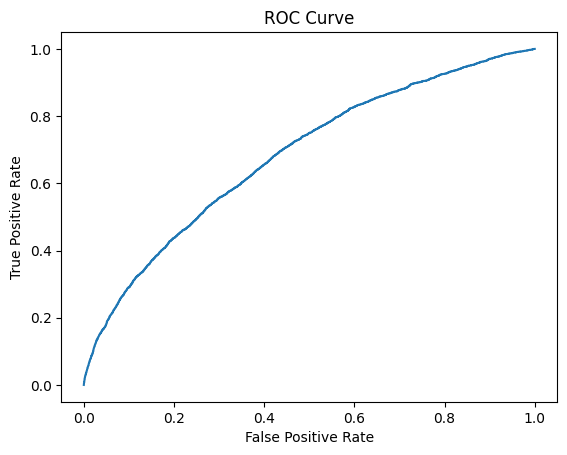

In [72]:
# 將特徵與目標變數分開
features = df.drop("ACCIDENT_TYPE", axis=1)
target = df["ACCIDENT_TYPE"]

# 分割資料為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42
)

# 計算類別權重
class_weights = compute_class_weight("balanced", classes=target.unique(), y=target)

# 將類別權重轉換為字典形式
class_weights_dict = {
    cls: weight for cls, weight in zip(target.unique(), class_weights)
}

# 定義Logistic RegressionCV模型並設置class_weight參數和cv參數
model = LogisticRegressionCV(class_weight=class_weights_dict, cv=30)

# 訓練完整的模型
model.fit(X_train, y_train)

# 在測試集上評估模型
accuracy = model.score(X_test, y_test)
recall = recall_score(y_test, model.predict(X_test), average="weighted")  # 使用加權平均計算召回率
f1 = f1_score(y_test, model.predict(X_test), average="weighted")  # 使用加權平均計算F1分數

print("Testing accuracy:", accuracy)
print("Recall:", recall)
print("F1 score:", f1)

# 訓練完模型後，獲取特徵重要性
feature_importance = abs(model.coef_[0])

# 將特徵名稱和其對應的重要性值組合成字典
feature_importance_dict = dict(zip(features.columns, feature_importance))

# 根據重要性值降序排序特徵
sorted_features = sorted(
    feature_importance_dict.items(), key=lambda x: x[1], reverse=True
)

# 顯示前幾個重要性最高的特徵
top_n = 20  # 可以根據需要自行調整顯示的數量
print(f"Top {top_n} important features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


# 在測試集上獲取預測機率
y_pred_prob = model.predict_proba(X_test)[:, 1]

# 計算AUC值
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC:", auc_score)

# 繪製ROC曲線
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# 將測試集資料和預測機率結果合併為一個 DataFrame
df_test_with_prob = X_test.copy()
df_test_with_prob["Probability"] = y_pred_prob
df_test_with_prob["ACCIDENT_TYPE"] = y_test  # 將目標變數加回表格

# 將合併後的 DataFrame 存為CSV檔
df_test_with_prob.to_csv("test_data_with_prob.csv", index=False)


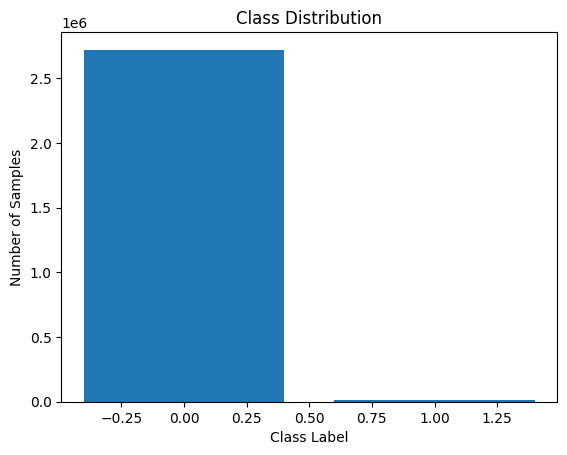

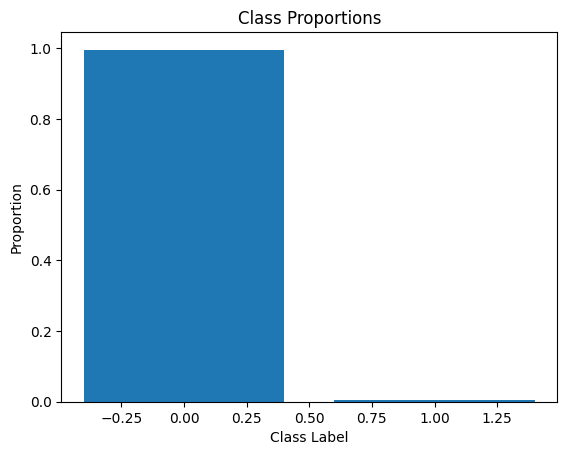

Imbalanced Ratio: 0.004081833545083269


In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# 假設你的資料集中的目標類別欄位名稱為"ACCIDENT_TYPE"
target_counts = df["ACCIDENT_TYPE"].value_counts()
class_labels = target_counts.index
class_counts = target_counts.values

# 繪製類別分佈圖
plt.bar(class_labels, class_counts)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()

# 計算類別比例
class_proportions = target_counts / len(df)

# 繪製類別比例圖
plt.bar(class_labels, class_proportions)
plt.xlabel("Class Label")
plt.ylabel("Proportion")
plt.title("Class Proportions")
plt.show()

# 計算不平衡比例
imbalanced_ratio = class_counts[1] / class_counts[0]
print("Imbalanced Ratio:", imbalanced_ratio)


Axes(0.125,0.11;0.775x0.77)


c:\Users\Ethen\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


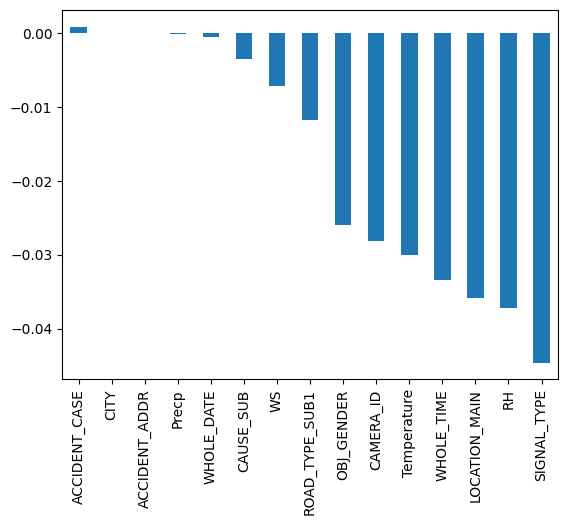

In [12]:
# To get the weights of all the variables

from sklearn.linear_model import LogisticRegression

# 创建并训练逻辑回归模型
model = LogisticRegression()
model.fit(X_train, y_train)

# 访问模型的系数
coefficients = model.coef_

weights = pd.Series(model.coef_[0], index=X_train.columns).transpose()
print(weights.sort_values(ascending=False)[:15].plot(kind="bar"))

Axes(0.125,0.11;0.775x0.77)


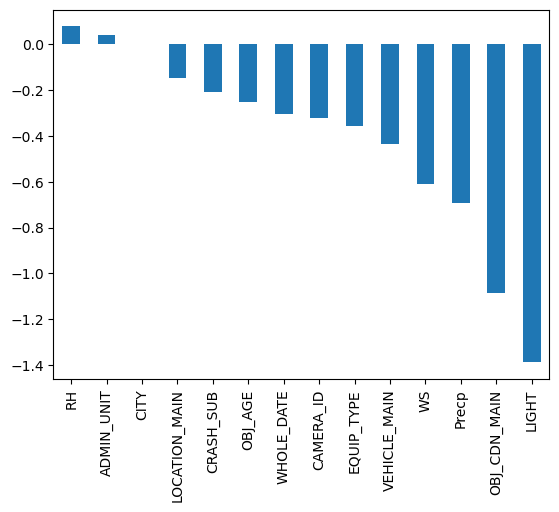

In [17]:
print(weights.sort_values(ascending=False)[-15:-1].plot(kind="bar"))


# 儲存Logistic Model

In [73]:
import pickle

# 將模型存儲為檔案
model_filename = "logistic_regression_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(model, file)

print("模型已成功存檔：", model_filename)


模型已成功存檔： logistic_regression_model.pkl


# Import Model

In [ ]:
# import pickle

# # 載入存儲的模型
# with open("logistic_regression_model.pkl", 'rb') as file:
#     loaded_model = pickle.load(file)

# 使用載入的模型進行預測等操作
# y_pred = loaded_model.predict(X_test)
# ...


In [ ]:
# import pandas as pd
# import pickle

# # 載入測試資料
# df_test = pd.read_csv("test_data_with_prob.csv")

# # 分割特徵和目標變數
# X_test = df_test.drop("ACCIDENT_TYPE", axis=1)
# y_test = df_test["ACCIDENT_TYPE"]

# # 載入模型
# with open("logistic_regression_model.pkl", "rb") as f:
#     model = pickle.load(f)

# # 使用模型進行預測
# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test)[:, 1]

# # 將預測結果和機率添加回DataFrame
# df_test["Predicted_ACCIDENT_TYPE"] = y_pred
# df_test["Probability"] = y_prob

# # 顯示結果
# print(df_test[["ACCIDENT_TYPE", "Predicted_ACCIDENT_TYPE", "Probability"]])
